In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)


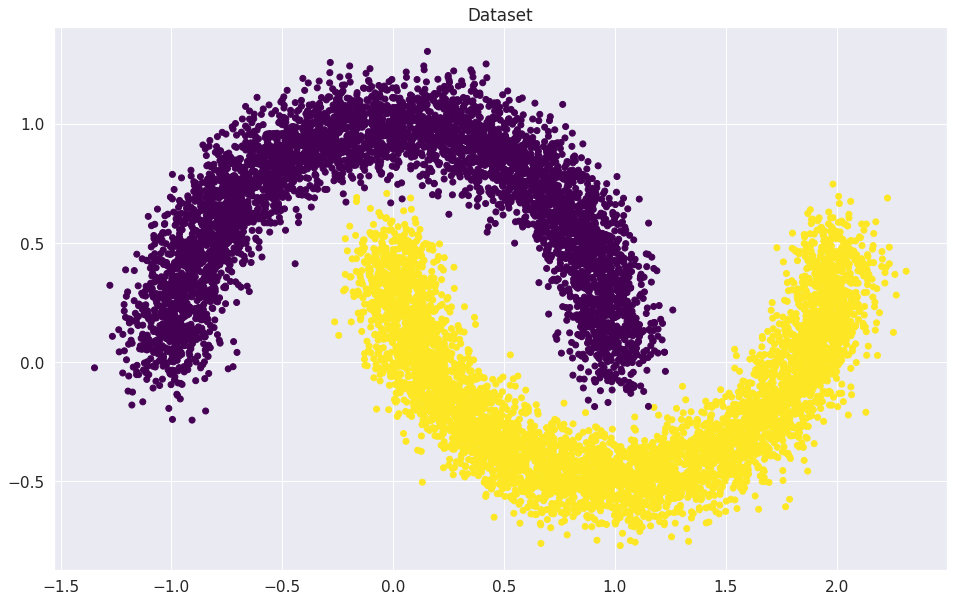

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [ ]:
X_train_t =  torch.from_numpy(X_train.astype(np.float32))
y_train_t =  torch.from_numpy( y_train.astype(np.float32))
X_val_t =  torch.from_numpy(X_val.astype(np.float32))
y_val_t =torch.from_numpy(y_val.astype(np.float32))

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [ ]:
print(X_train_t.shape ,y_train_t.shape ,X_val_t.shape,y_val_t.shape )

torch.Size([7500, 2]) torch.Size([7500]) torch.Size([2500, 2]) torch.Size([2500])


In [ ]:
class LinearRegression(nn.Module):
    
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
    
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features,out_features,dtype=torch.float32))
        self.bias = bias

        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features,dtype=torch.float32))
        self.linear = torch.nn.Linear(in_features,out_features)
        
    def forward(self, x):
        
        x =  x@self.weights
        
        if self.bias:
            x +=  self.bias_term
        
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

Вопрос 1. Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.
Ответ:3

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()

        outp = linear_regression.forward(X_batch)

        loss = loss_function(outp,y_batch.unsqueeze(1)) 
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = F.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 0
Batch accuracy: 0.515625
Iteration: 100
Batch accuracy: 0.84375
Iteration: 200
Batch accuracy: 0.8203125
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.875
Iteration: 700
Batch accuracy: 0.828125

Iteration: 755.Convergence. Stopping iterations.


Вопрос 2. Сколько итераций потребовалось, чтобы алгоритм сошелся?
755

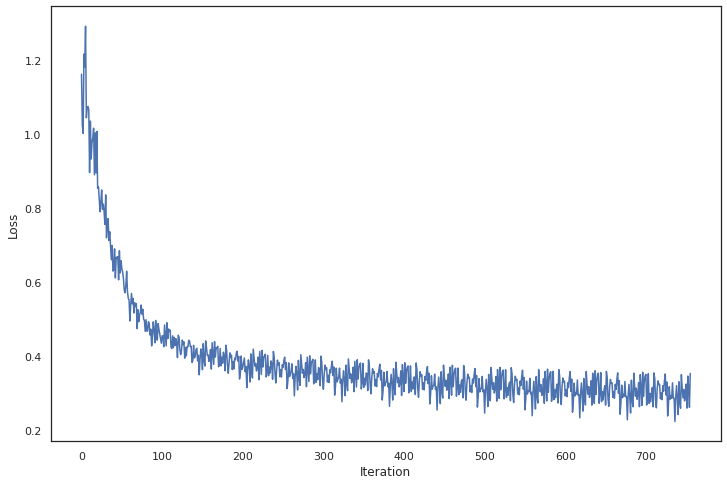

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

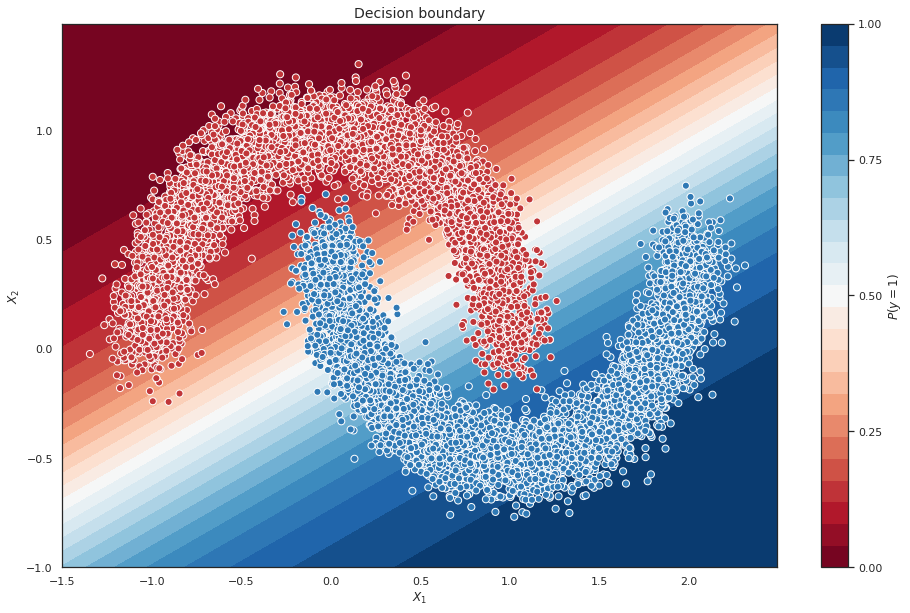

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        # <YOUR CODE>
        preds = np.around(F.sigmoid(model.forward(x_batch)))
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

# a = predict(train_dataloader,linear_regression )

a = predict(val_dataloader,linear_regression )


print("accuracy_score",accuracy_score(a,y_val))


accuracy_score 0.864


Какое accuracy получается после обучения?

Ответ:0.864

In [ ]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

In [ ]:
print(train_dataset,val_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           ) Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [ ]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,128),
    activation(),
    # nn.ReLU,
    # nn.Linear(500,128),
    # nn.ELU(),
    nn.Linear(128,10),
    activation()

)
print(model,model.parameters())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=10, bias=True)
  (4): ELU(alpha=1.0)
) <generator object Module.parameters at 0x7f99769fa900>


In [ ]:
nn.ReLU

torch.nn.modules.activation.ReLU

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.99115
Loader: valid. Accuracy: 0.969
Epoch: 2
Loader: train. Accuracy: 0.9918
Loader: valid. Accuracy: 0.968
Epoch: 3
Loader: train. Accuracy: 0.9918666666666667
Loader: valid. Accuracy: 0.9707
Epoch: 4
Loader: train. Accuracy: 0.9935333333333334
Loader: valid. Accuracy: 0.9698
Epoch: 5
Loader: train. Accuracy: 0.9937333333333334
Loader: valid. Accuracy: 0.9731
Epoch: 6
Loader: train. Accuracy: 0.9940666666666667
Loader: valid. Accuracy: 0.9687
Epoch: 7
Loader: train. Accuracy: 0.994
Loader: valid. Accuracy: 0.9728
Epoch: 8
Loader: train. Accuracy: 0.9939166666666667
Loader: valid. Accuracy: 0.9704
Epoch: 9
Loader: train. Accuracy: 0.9944666666666667
Loader: valid. Accuracy: 0.9739
Epoch: 10
Loader: train. Accuracy: 0.99425
Loader: valid. Accuracy: 0.9722


In [ ]:
elu_accuracy = accuracy["valid"] 
print(elu_accuracy)

[0.969, 0.968, 0.9707, 0.9698, 0.9731, 0.9687, 0.9728, 0.9704, 0.9739, 0.9722]


In [ ]:
elu_accuracy = accuracy["valid"] 
def test_activation_function(activation):
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,128),
    activation(),
    nn.Linear(128,10),
    activation())
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    max_epochs = 10
    accuracy = {"train": [], "valid": []}

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            # if k == "train":
                # print(f"Epoch: {epoch+1}")
            # print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy['valid']

In [ ]:
plain_accuracy = test_activation_function(Identical)

In [ ]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

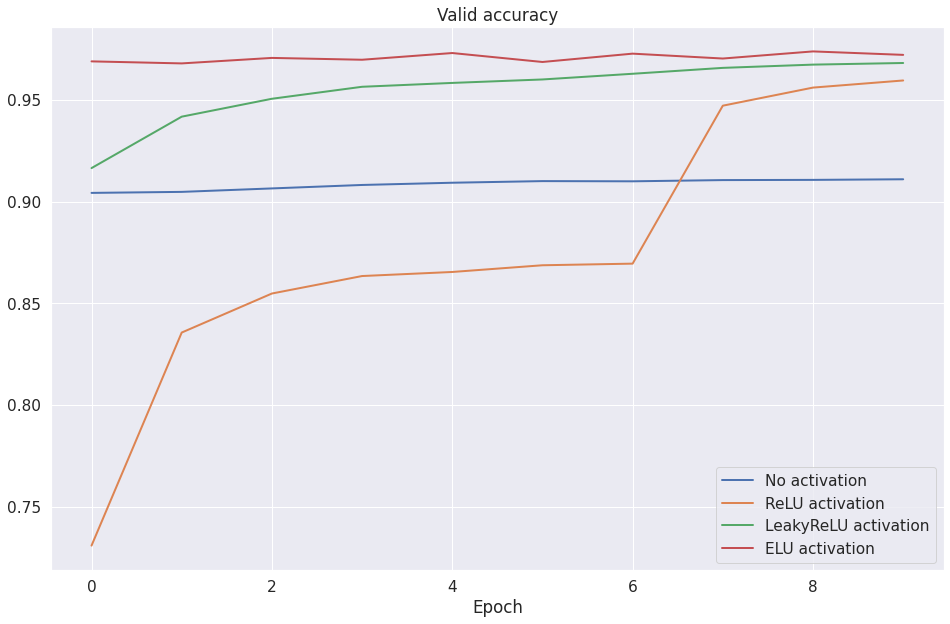

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

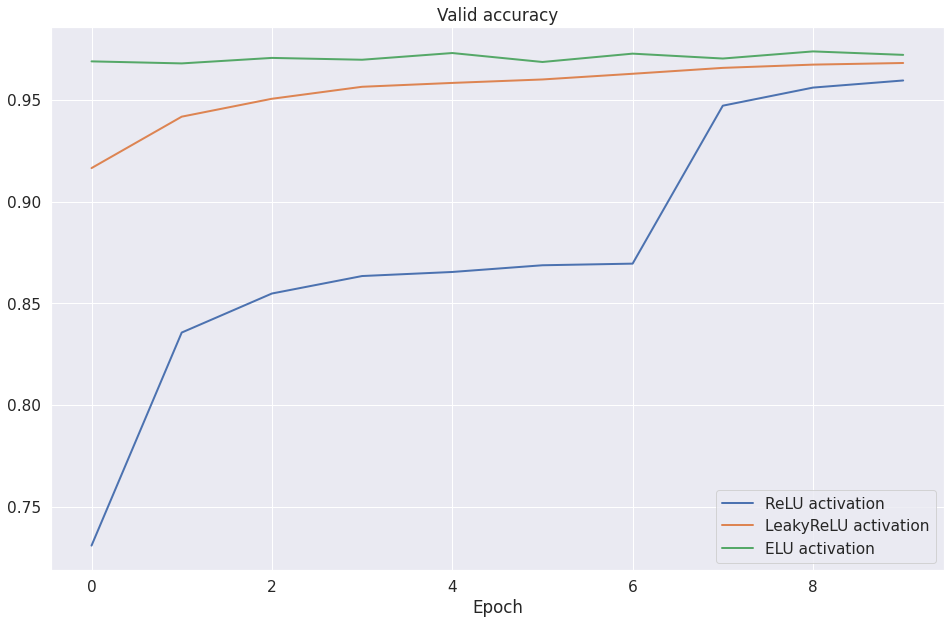

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

Вопрос 4. Какая из активаций показала наивысший accuracy к концу обучения?

Ответ:ELU

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-12-06 12:54:12--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-12-06 12:54:12--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   261KB/s    in 0.2s    

2022-12-06 12:54:13 (261 KB/s) - ‘sample_photo.jpg’ saved [49337/4

In [ ]:
!pip install mss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 5.5 MB/s 


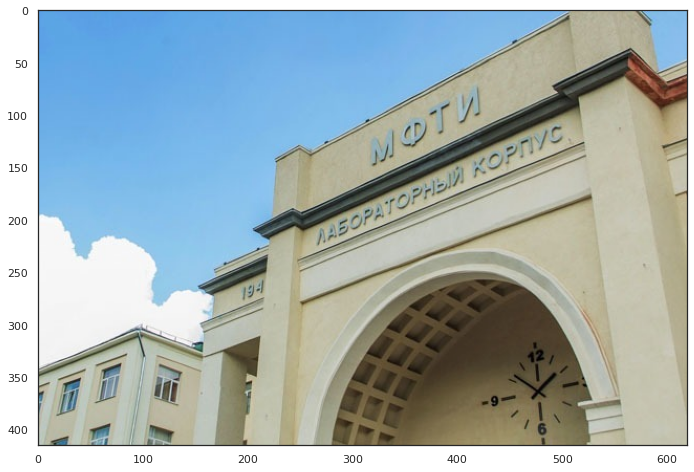

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

In [ ]:
# A = [[0, 0, 0],
# [0, 1, 0],
# [0, 0, 0]]
# B = [[0, 1, 0],
# [0, -2, 0],
# [0, 1, 0]]
# C = [[0, 0, 0],
# [1, -2, 1],
# [0, 0, 0]]
# D = [[0, 1, 0],
# [1, -4, 1],
# [0, 1, 0]]
# E = [[0, -1, 0],
# [-1, 5, -1],
# [0, -1, 0]]
# F =[[0.0625, 0.125, 0.0625],
# [0.125, 0.25, 0.125],
# [0.0625, 0.125, 0.0625]]

img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

# result = F.conv2d(img_t, kernel)[0]  #

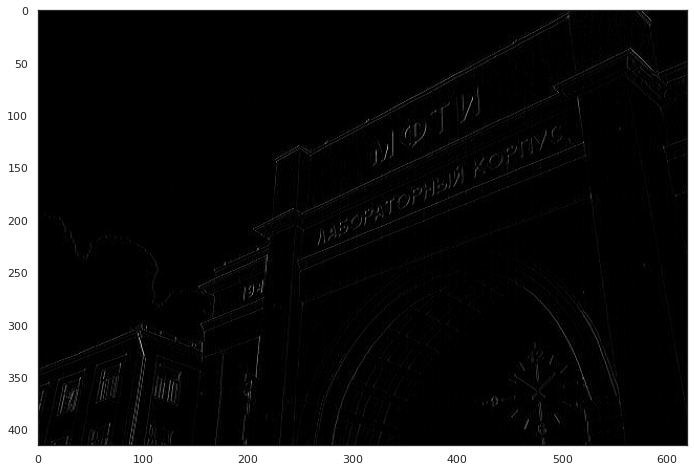

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

Вопрос 5. Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие -E

2) Увеличение резкости -Д

3) Тождественное преобразование -А

4) Выделение вертикальных границ -Б

5) Выделение горизонтальных границ -В

6) Выделение границ -Г



In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 =  nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))  
        x = self.pool2(F.relu(self.conv2(x)))  
        x = self.fl(x)            
        x = F.relu(self.fc1(x))               
        x = F.relu(self.fc2(x))             
        x = self.fc3(x)
        
        return x

In [ ]:
# learning_rate = 0.001
model = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                outp = model.forward(x_batch)
                loss = criterion(outp, y_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8792333333333333
Loader: valid. Accuracy: 0.9638
Epoch: 2
Loader: train. Accuracy: 0.9683
Loader: valid. Accuracy: 0.9751
Epoch: 3
Loader: train. Accuracy: 0.9787666666666667
Loader: valid. Accuracy: 0.9817
Epoch: 4
Loader: train. Accuracy: 0.9831166666666666
Loader: valid. Accuracy: 0.9834
Epoch: 5
Loader: train. Accuracy: 0.986
Loader: valid. Accuracy: 0.9855
Epoch: 6
Loader: train. Accuracy: 0.9885
Loader: valid. Accuracy: 0.9858
Epoch: 7
Loader: train. Accuracy: 0.9904333333333334
Loader: valid. Accuracy: 0.9861
Epoch: 8
Loader: train. Accuracy: 0.9914666666666667
Loader: valid. Accuracy: 0.9866
Epoch: 9
Loader: train. Accuracy: 0.9925166666666667
Loader: valid. Accuracy: 0.987
Epoch: 10
Loader: train. Accuracy: 0.99335
Loader: valid. Accuracy: 0.9876


In [ ]:
lenet_accuracy=accuracy['valid']

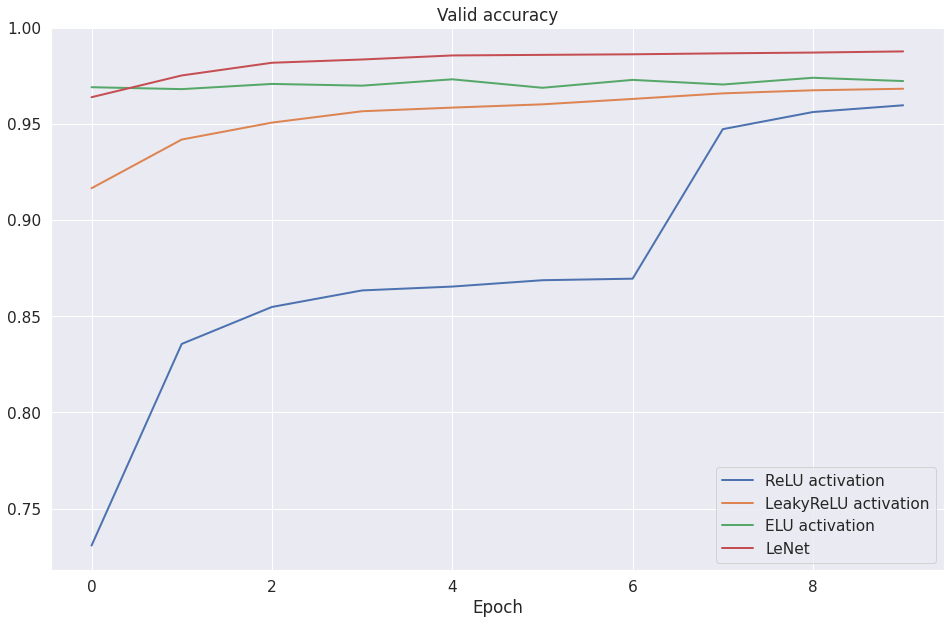

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
print(round(lenet_accuracy[-1],2))

0.99


Вопрос 6 Какое accuracy получается после обучения с точностью до двух знаков после запятой?

Ответ:0.99